In [476]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from itertools import accumulate

In [631]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=0.1):
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.thetas = np.random.uniform(-1, 1, k)
        self.thetas = np.linspace(-1, 1, k)
        self.parameters = self.estimate_parameters()
        self.true_theta_PO = self.true_performative_optimum()
        self.estimated_theta_PO = self.estimated_performative_optimum()
        self.losses = self.running_expected_loss()
        
    def f(self, theta):

        fun = 3 + np.sin(theta - 2) + np.sin(theta)**2
        fun = 1 + theta * np.cos(5 * theta) + np.sin(theta - 2)**2 + theta * np.sin(theta + 3) * np.cos(theta + 3)

        return fun
    
    def generate_y(self, theta):

        return self.f(theta) + np.random.normal(0, self.sigma, self.n)
    
    def estimate_f(self, theta):

        return np.mean(self.generate_y(theta))
    
    def vandermonde_matrix(self):

        return np.column_stack([self.thetas**i for i in range(self.k)])
    
    def estimate_parameters(self):

        V = self.vandermonde_matrix()
        f_estimates = np.zeros(self.k)
        for i in range(self.k):
            f_estimates[i] = self.estimate_f(self.thetas[i])

        return np.linalg.inv(V) @ f_estimates
    
    def polynomial_f(self, x):

        value = 0
        for i in range(self.k):
            value += x**i * self.parameters[i]

        return value 
    
    def true_objective_function(self, x):

        return self.f(x)**2 + x**2 - 2 * x * self.f(x)
    
    def estimated_objective_function(self, x):

        p = self.polynomial_f(x)

        return p**2 + x**2 - 2 * x * p
    
    def estimated_performative_optimum(self):

        result = minimize_scalar(self.estimated_objective_function, bounds=(-1, 1), method='bounded')
        return result.x
    
    def true_performative_optimum(self):

        result = minimize_scalar(self.true_objective_function, bounds=(-1, 1), method='bounded')
        return result.x
    
    def plot_everything(self):
        
        t1 = np.linspace(-2, 2, 1000)
        t2 = np.linspace(-1, 1, 1000)

        plt.figure(figsize=(10, 7))
        plt.plot(t1, self.f(t1), label=r'$f(\theta)$')
        plt.plot(t1, self.true_objective_function(t1), 'k', label='true objective')
        plt.plot(t2, self.estimated_objective_function(t2), 'r--', label=f'estimated objective for k={self.k}')
        plt.scatter(self.true_theta_PO, self.true_objective_function(self.true_theta_PO), label=r"true $\theta_{PO}$", color='k')
        plt.scatter(self.estimated_theta_PO, self.estimated_objective_function(self.estimated_theta_PO), label=r"estimated $\theta_{PO}$", color='r', alpha=0.9)
        plt.fill_between(t2, 0, 25, color='C0', alpha=0.3)
        plt.xlabel(r"$\theta$")
        plt.ylim(0, 25)
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()

    def expected_loss(self, theta):

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def running_expected_loss(self):
        
        losses = []
        for theta in self.thetas:

            losses.extend([self.expected_loss(theta) for _ in range(self.n)])
            
        losses.extend([self.expected_loss(self.estimated_theta_PO) for _ in range(self.T - self.k * self.n)])

        return losses
    
    def cumulative_losses(self, optimal=False):

        if optimal:
            return list(accumulate(self.optimal_losses()))
        else:
            return list(accumulate(self.losses))
    
    def optimal_losses(self):

        return np.ones(self.T) * self.expected_loss(self.true_theta_PO)
    

        


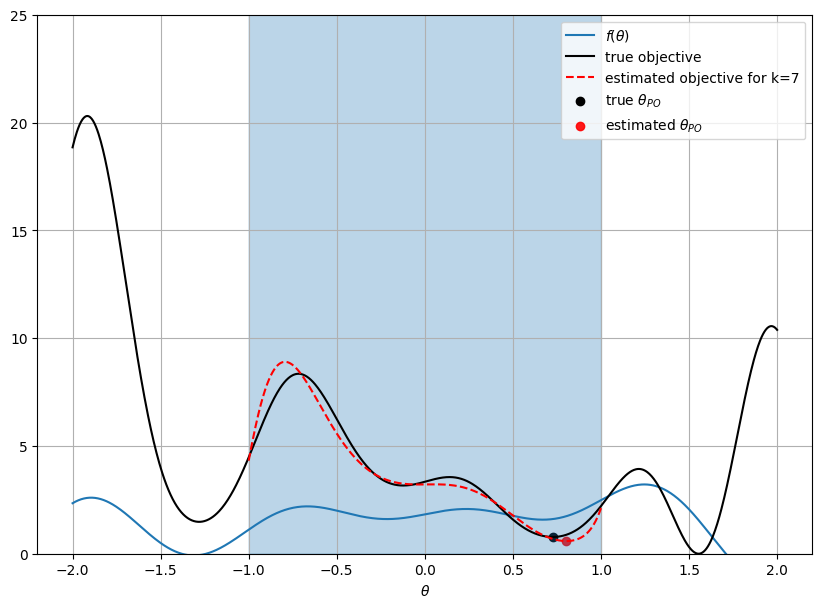

In [632]:
pr = Performative_Regression(k=7, n=10, T=500)
pr.plot_everything()

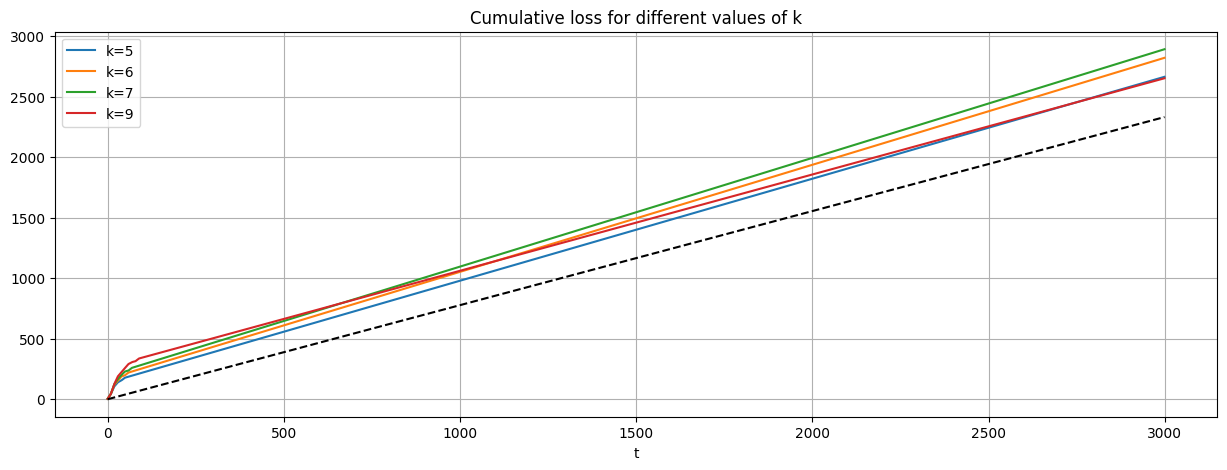

In [640]:
plt.figure(figsize=(15, 5))
for k in [5, 6, 7, 9]:
    pr = Performative_Regression(k=k, n=10, T=3000)
    plt.plot(pr.cumulative_losses(), label=f"k={k}")
plt.plot(pr.cumulative_losses(optimal=True), 'k--')
plt.title("Cumulative loss for different values of k")
plt.xlabel("t")
plt.legend()
plt.grid()
plt.show()
